# 🤖 Model Training: RandomForest para Predicción de Brotes en Crohn

**Objetivo:** Entrenar y optimizar un modelo RandomForest para predecir risk_level (low/medium/high)

**Input:** `../data/processed/ml_dataset.csv` (del notebook 02)

**Output:** Modelo entrenado (.pkl) listo para producción

**Autor:** Asier Ortiz García

**Fecha:** Noviembre 2025

---

## 📋 Plan de Entrenamiento

### Problema Identificado:
**Desbalance severo de clases:**
- Low: 76.2% (12,075 casos)
- Medium: 22.3% (3,538 casos)
- High: 1.5% (234 casos) ⚠️ MUY POCOS

### Estrategia de Solución:
Entrenaremos **3 modelos** y compararemos:

1. **Baseline:** Solo `class_weight='balanced'`
2. **SMOTE Moderado:** Oversampling moderado + class_weight
3. **SMOTE Agresivo:** Balanceo completo + class_weight

### Métricas de Evaluación:
- **F1-Score por clase** (más importante que accuracy)
- **Recall para HIGH** (crítico - detectar todos los brotes)
- **Precision para HIGH** (evitar falsos positivos)
- **Confusion Matrix**

### Selección del Mejor Modelo:
Priorizaremos **F1-score y Recall de la clase HIGH**, ya que es crítico no perder brotes reales.

## 📦 Imports y Configuración

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
from datetime import datetime
import warnings
import os
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    f1_score, precision_score, recall_score, accuracy_score,
    roc_auc_score, make_scorer
)
from sklearn.preprocessing import LabelEncoder

# Imbalanced-learn (SMOTE)
from imblearn.over_sampling import SMOTE
from collections import Counter

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10
%matplotlib inline

# Crear directorios
os.makedirs('../models', exist_ok=True)
os.makedirs('../docs/figures', exist_ok=True)

print("=" * 80)
print("MODEL TRAINING: RandomForest con Manejo de Desbalance de Clases")
print("=" * 80)

MODEL TRAINING: RandomForest con Manejo de Desbalance de Clases


## 1️⃣ Cargar Dataset y Metadata

In [2]:
print("📊 Cargando dataset procesado...\n")

# Cargar dataset
df = pd.read_csv('../data/processed/ml_dataset.csv')

# Cargar metadata
with open('../data/processed/ml_dataset_metadata.json', 'r') as f:
    metadata = json.load(f)

print(f"✓ Dataset cargado: {len(df):,} registros")
print(f"✓ Features: {len(metadata['features'])}")
print(f"✓ Target: {metadata['target']}")

print(f"\n📋 Features disponibles:")
for category, features in [
    ('Síntomas', metadata['symptom_features']),
    ('Demográficos', metadata['demographic_features']),
    ('Historial', metadata['history_features']),
    ('Temporales', metadata['temporal_features'])
]:
    print(f"  {category}: {features}")

print(f"\n📊 Distribución de clases:")
class_dist = df[metadata['target']].value_counts()
for cls, count in class_dist.items():
    pct = count / len(df) * 100
    print(f"  {cls.upper():8} {count:6,} ({pct:5.1f}%)")

📊 Cargando dataset procesado...

✓ Dataset cargado: 15,847 registros
✓ Features: 13
✓ Target: risk_level

📋 Features disponibles:
  Síntomas: ['abdominal_pain', 'blood_in_stool', 'diarrhea', 'fatigue', 'fever', 'nausea']
  Demográficos: ['age', 'gender']
  Historial: ['disease_duration_years', 'previous_flares', 'last_flare_days_ago']
  Temporales: ['month', 'day_of_week']

📊 Distribución de clases:
  LOW      12,075 ( 76.2%)
  MEDIUM    3,538 ( 22.3%)
  HIGH        234 (  1.5%)


In [3]:
# Vista previa del dataset
df.head(10)

,abdominal_pain,blood_in_stool,diarrhea,fatigue,fever,nausea,age,gender,disease_duration_years,previous_flares,last_flare_days_ago,month,day_of_week,risk_level,user_id,checkin_date
0,0.00,0.0,1.00,0.00,0.0,1.00,26.0,F,0.005476,0,365,3,3,medium,QEVuQwEA+/IvXrvEfxv3K+i06e/FkQ==,2019-03-07
1,0.75,0.0,0.75,1.00,0.0,1.00,26.0,F,0.008214,0,365,3,4,medium,QEVuQwEA+/IvXrvEfxv3K+i06e/FkQ==,2019-03-08
2,0.00,0.0,0.00,1.00,0.0,0.25,32.0,F,0.000000,0,365,6,1,low,QEVuQwEA+09Bf3/070wupBLkeAmzNg==,2017-06-27
3,1.00,0.0,0.00,0.50,0.0,0.00,32.0,F,0.000000,0,365,5,1,medium,QEVuQwEA+3RzvDD4EFPgYN/hT3sZYQ==,2015-05-26
4,0.75,0.0,0.00,0.75,0.0,0.00,32.0,F,0.008214,0,365,5,4,medium,QEVuQwEA+3RzvDD4EFPgYN/hT3sZYQ==,2015-05-29
5,0.50,0.0,0.00,0.50,0.0,0.00,32.0,F,0.013689,0,365,5,6,low,QEVuQwEA+3RzvDD4EFPgYN/hT3sZYQ==,2015-05-31
6,0.50,0.0,0.00,1.00,0.0,0.00,32.0,F,0.079398,0,365,6,2,low,QEVuQwEA+3RzvDD4EFPgYN/hT3sZYQ==,2015-06-24
7,0.50,0.0,0.50,1.00,0.0,0.50,37.0,F,0.000000,0,365,8,2,medium,QEVuQwEA+47+KNebsMZxVzP77llQYQ==,2018-08-29
8,0.50,0.0,0.25,0.75,0.0,0.25,37.0,F,0.005476,0,365,8,4,medium,QEVuQwEA+47+KNebsMZxVzP77llQYQ==,2018-08-31
9,0.50,0.0,0.00,0.50,0.0,0.50,37.0,F,0.008214,0,365,9,5,low,QEVuQwEA+47+KNebsMZxVzP77llQYQ==,2018-09-01


## 2️⃣ Preparar Datos para Entrenamiento

In [4]:
# Separar features y target
feature_cols = metadata['features']
target_col = metadata['target']

X = df[feature_cols].copy()
y = df[target_col].copy()

print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")

# Encode categorical features (gender)
if 'gender' in X.columns:
    gender_map = {'M': 1, 'F': 2, 'O': 0}
    X['gender'] = X['gender'].map(gender_map)
    print(f"\n✓ Gender encoded: {dict(X['gender'].value_counts())}")

# Verificar que no hay valores faltantes
missing = X.isnull().sum().sum()
if missing > 0:
    print(f"\n⚠️  {missing} valores faltantes encontrados - imputando...")
    X.fillna(X.median(), inplace=True)
else:
    print(f"\n✓ Sin valores faltantes")

print(f"\nFeature names:")
print(X.columns.tolist())

Features (X): (15847, 13)
Target (y): (15847,)

✓ Gender encoded: {2: np.int64(12067), 1: np.int64(2401), 0: np.int64(1379)}

✓ Sin valores faltantes

Feature names:
['abdominal_pain', 'blood_in_stool', 'diarrhea', 'fatigue', 'fever', 'nausea', 'age', 'gender', 'disease_duration_years', 'previous_flares', 'last_flare_days_ago', 'month', 'day_of_week']


## 3️⃣ Train/Test Split (Estratificado)

In [5]:
# Split con estratificación para mantener proporciones de clases
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,  # Importante: mantener proporciones
    random_state=42
)

print(f"Train set: {X_train.shape[0]:,} samples")
print(f"Test set:  {X_test.shape[0]:,} samples")

print(f"\nDistribución en Train:")
train_dist = y_train.value_counts()
for cls, count in train_dist.items():
    pct = count / len(y_train) * 100
    print(f"  {cls.upper():8} {count:5,} ({pct:5.1f}%)")

print(f"\nDistribución en Test:")
test_dist = y_test.value_counts()
for cls, count in test_dist.items():
    pct = count / len(y_test) * 100
    print(f"  {cls.upper():8} {count:5,} ({pct:5.1f}%)")

Train set: 12,677 samples
Test set:  3,170 samples

Distribución en Train:
  LOW      9,660 ( 76.2%)
  MEDIUM   2,830 ( 22.3%)
  HIGH       187 (  1.5%)

Distribución en Test:
  LOW      2,415 ( 76.2%)
  MEDIUM     708 ( 22.3%)
  HIGH        47 (  1.5%)


## 4️⃣ Modelo 1: Baseline (Solo class_weight)

Entrenamos sin modificar los datos, solo usando pesos balanceados.

In [6]:
print("\n" + "="*80)
print("🌲 MODELO 1: Baseline - Solo class_weight='balanced'")
print("="*80 + "\n")

# Entrenar modelo baseline
model_baseline = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=4,
    class_weight='balanced',  # Peso automático según frecuencia inversa
    random_state=42,
    n_jobs=-1
)

print("Entrenando modelo baseline...")
model_baseline.fit(X_train, y_train)
print("✓ Entrenamiento completado\n")

# Predicciones
y_pred_baseline = model_baseline.predict(X_test)
y_pred_proba_baseline = model_baseline.predict_proba(X_test)

# Métricas
print("📊 Métricas en Test Set:\n")
print(classification_report(y_test, y_pred_baseline, 
                          target_names=['low', 'medium', 'high'],
                          digits=3))

# Accuracy
acc_baseline = accuracy_score(y_test, y_pred_baseline)
print(f"\nAccuracy: {acc_baseline:.3f}")

# F1 scores por clase
f1_baseline = f1_score(y_test, y_pred_baseline, average=None, labels=['low', 'medium', 'high'])
print(f"\nF1-Scores por clase:")
for cls, score in zip(['low', 'medium', 'high'], f1_baseline):
    print(f"  {cls.upper():8} {score:.3f}")

# Macro F1 (promedio)
macro_f1_baseline = f1_score(y_test, y_pred_baseline, average='macro')
print(f"\nMacro F1-Score: {macro_f1_baseline:.3f}")


🌲 MODELO 1: Baseline - Solo class_weight='balanced'

Entrenando modelo baseline...
✓ Entrenamiento completado



📊 Métricas en Test Set:



              precision    recall  f1-score   support

         low      0.772     0.936     0.846        47
      medium      0.996     0.992     0.994      2415
        high      0.969     0.968     0.968       708

    accuracy                          0.986      3170
   macro avg      0.912     0.965     0.936      3170
weighted avg      0.987     0.986     0.986      3170


Accuracy: 0.986

F1-Scores por clase:
  LOW      0.994
  MEDIUM   0.968
  HIGH     0.846

Macro F1-Score: 0.936


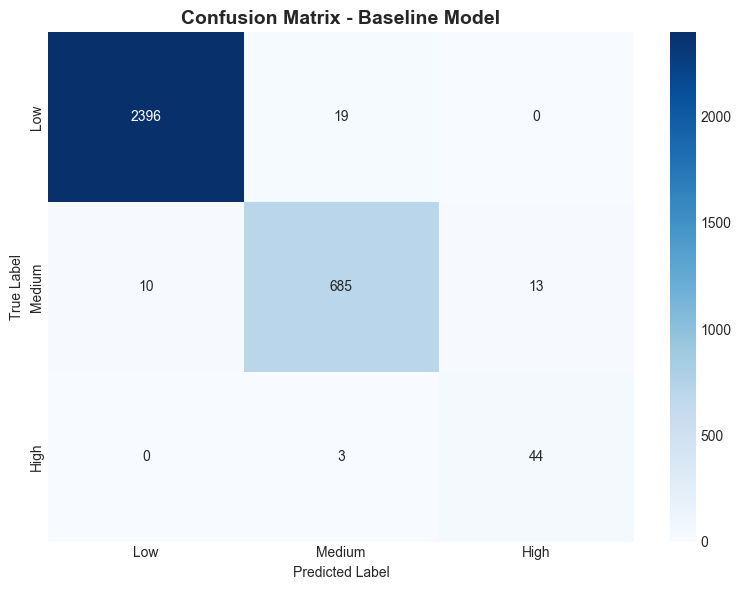

💾 Guardado: ../docs/figures/cm_baseline.png


In [7]:
# Confusion Matrix - Baseline
cm_baseline = confusion_matrix(y_test, y_pred_baseline, labels=['low', 'medium', 'high'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.title('Confusion Matrix - Baseline Model', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('../docs/figures/cm_baseline.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"💾 Guardado: ../docs/figures/cm_baseline.png")

## 5️⃣ Modelo 2: SMOTE Moderado + class_weight

Aplicamos SMOTE con oversampling moderado (no balancear completamente).

In [8]:
print("\n" + "="*80)
print("🌲 MODELO 2: SMOTE Moderado + class_weight='balanced'")
print("="*80 + "\n")

# Configurar SMOTE moderado
# Aumentar medium y high, pero no llegar a 50-50-50
train_counts = Counter(y_train)
print(f"Distribución ANTES de SMOTE:")
for cls, count in train_counts.items():
    print(f"  {cls.upper():8} {count:5,}")

# Estrategia: Aumentar high a ~15% y medium a ~35%
total_train = len(y_train)
target_high = int(total_train * 0.15)  # ~1,900 casos
target_medium = int(total_train * 0.35)  # ~4,400 casos

smote_moderate = SMOTE(
    sampling_strategy={
        'high': target_high,
        'medium': target_medium
    },
    random_state=42
)

print(f"\nAplicando SMOTE moderado...")
X_train_smote_mod, y_train_smote_mod = smote_moderate.fit_resample(X_train, y_train)

smote_mod_counts = Counter(y_train_smote_mod)
print(f"\nDistribución DESPUÉS de SMOTE moderado:")
for cls in ['low', 'medium', 'high']:
    count = smote_mod_counts[cls]
    pct = count / len(y_train_smote_mod) * 100
    print(f"  {cls.upper():8} {count:5,} ({pct:5.1f}%)")

print(f"\nTotal train samples: {len(y_train):,} → {len(y_train_smote_mod):,}")


🌲 MODELO 2: SMOTE Moderado + class_weight='balanced'

Distribución ANTES de SMOTE:
  LOW      9,660
  MEDIUM   2,830
  HIGH       187

Aplicando SMOTE moderado...



Distribución DESPUÉS de SMOTE moderado:
  LOW      9,660 ( 60.4%)
  MEDIUM   4,436 ( 27.7%)
  HIGH     1,901 ( 11.9%)

Total train samples: 12,677 → 15,997


In [9]:
# Entrenar modelo con SMOTE moderado
model_smote_mod = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=4,
    class_weight='balanced',  # Peso adicional
    random_state=42,
    n_jobs=-1
)

print("\nEntrenando modelo con SMOTE moderado...")
model_smote_mod.fit(X_train_smote_mod, y_train_smote_mod)
print("✓ Entrenamiento completado\n")

# Predicciones (en test set ORIGINAL, sin SMOTE)
y_pred_smote_mod = model_smote_mod.predict(X_test)
y_pred_proba_smote_mod = model_smote_mod.predict_proba(X_test)

# Métricas
print("📊 Métricas en Test Set:\n")
print(classification_report(y_test, y_pred_smote_mod, 
                          target_names=['low', 'medium', 'high'],
                          digits=3))

acc_smote_mod = accuracy_score(y_test, y_pred_smote_mod)
print(f"\nAccuracy: {acc_smote_mod:.3f}")

f1_smote_mod = f1_score(y_test, y_pred_smote_mod, average=None, labels=['low', 'medium', 'high'])
print(f"\nF1-Scores por clase:")
for cls, score in zip(['low', 'medium', 'high'], f1_smote_mod):
    print(f"  {cls.upper():8} {score:.3f}")

macro_f1_smote_mod = f1_score(y_test, y_pred_smote_mod, average='macro')
print(f"\nMacro F1-Score: {macro_f1_smote_mod:.3f}")


Entrenando modelo con SMOTE moderado...


✓ Entrenamiento completado

📊 Métricas en Test Set:



              precision    recall  f1-score   support

         low      0.898     0.936     0.917        47
      medium      0.995     0.996     0.996      2415
        high      0.982     0.977     0.979       708

    accuracy                          0.991      3170
   macro avg      0.958     0.970     0.964      3170
weighted avg      0.991     0.991     0.991      3170




Accuracy: 0.991

F1-Scores por clase:
  LOW      0.996
  MEDIUM   0.979
  HIGH     0.917

Macro F1-Score: 0.964


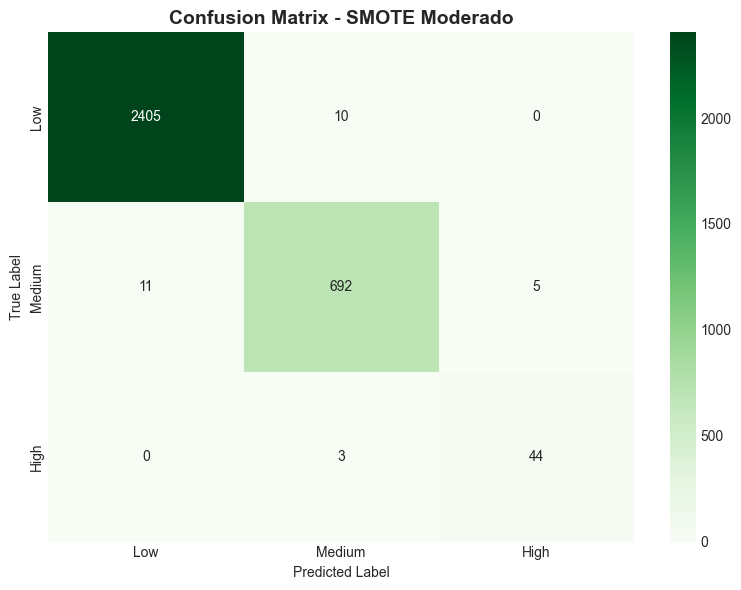

💾 Guardado: ../docs/figures/cm_smote_moderate.png


In [10]:
# Confusion Matrix - SMOTE Moderado
cm_smote_mod = confusion_matrix(y_test, y_pred_smote_mod, labels=['low', 'medium', 'high'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_smote_mod, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.title('Confusion Matrix - SMOTE Moderado', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('../docs/figures/cm_smote_moderate.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"💾 Guardado: ../docs/figures/cm_smote_moderate.png")

## 6️⃣ Modelo 3: SMOTE Agresivo + class_weight

Balanceamos completamente las tres clases (33%-33%-33%).

In [11]:
print("\n" + "="*80)
print("🌲 MODELO 3: SMOTE Agresivo (Balanceo Completo) + class_weight")
print("="*80 + "\n")

# SMOTE con balanceo completo
smote_aggressive = SMOTE(
    sampling_strategy='auto',  # Balancear todas las clases al nivel de la mayoría
    random_state=42
)

print(f"Aplicando SMOTE agresivo (balanceo completo)...")
X_train_smote_agg, y_train_smote_agg = smote_aggressive.fit_resample(X_train, y_train)

smote_agg_counts = Counter(y_train_smote_agg)
print(f"\nDistribución DESPUÉS de SMOTE agresivo:")
for cls in ['low', 'medium', 'high']:
    count = smote_agg_counts[cls]
    pct = count / len(y_train_smote_agg) * 100
    print(f"  {cls.upper():8} {count:5,} ({pct:5.1f}%)")

print(f"\nTotal train samples: {len(y_train):,} → {len(y_train_smote_agg):,}")


🌲 MODELO 3: SMOTE Agresivo (Balanceo Completo) + class_weight

Aplicando SMOTE agresivo (balanceo completo)...



Distribución DESPUÉS de SMOTE agresivo:
  LOW      9,660 ( 33.3%)
  MEDIUM   9,660 ( 33.3%)
  HIGH     9,660 ( 33.3%)

Total train samples: 12,677 → 28,980


In [12]:
# Entrenar modelo con SMOTE agresivo
model_smote_agg = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=4,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

print("\nEntrenando modelo con SMOTE agresivo...")
model_smote_agg.fit(X_train_smote_agg, y_train_smote_agg)
print("✓ Entrenamiento completado\n")

# Predicciones
y_pred_smote_agg = model_smote_agg.predict(X_test)
y_pred_proba_smote_agg = model_smote_agg.predict_proba(X_test)

# Métricas
print("📊 Métricas en Test Set:\n")
print(classification_report(y_test, y_pred_smote_agg, 
                          target_names=['low', 'medium', 'high'],
                          digits=3))

acc_smote_agg = accuracy_score(y_test, y_pred_smote_agg)
print(f"\nAccuracy: {acc_smote_agg:.3f}")

f1_smote_agg = f1_score(y_test, y_pred_smote_agg, average=None, labels=['low', 'medium', 'high'])
print(f"\nF1-Scores por clase:")
for cls, score in zip(['low', 'medium', 'high'], f1_smote_agg):
    print(f"  {cls.upper():8} {score:.3f}")

macro_f1_smote_agg = f1_score(y_test, y_pred_smote_agg, average='macro')
print(f"\nMacro F1-Score: {macro_f1_smote_agg:.3f}")


Entrenando modelo con SMOTE agresivo...


✓ Entrenamiento completado

📊 Métricas en Test Set:

              precision    recall  f1-score   support

         low      0.911     0.872     0.891        47
      medium      0.993     0.998     0.996      2415
        high      0.984     0.972     0.978       708

    accuracy                          0.990      3170
   macro avg      0.963     0.947     0.955      3170
weighted avg      0.990     0.990     0.990      3170


Accuracy: 0.990

F1-Scores por clase:
  LOW      0.996
  MEDIUM   0.978
  HIGH     0.891

Macro F1-Score: 0.955


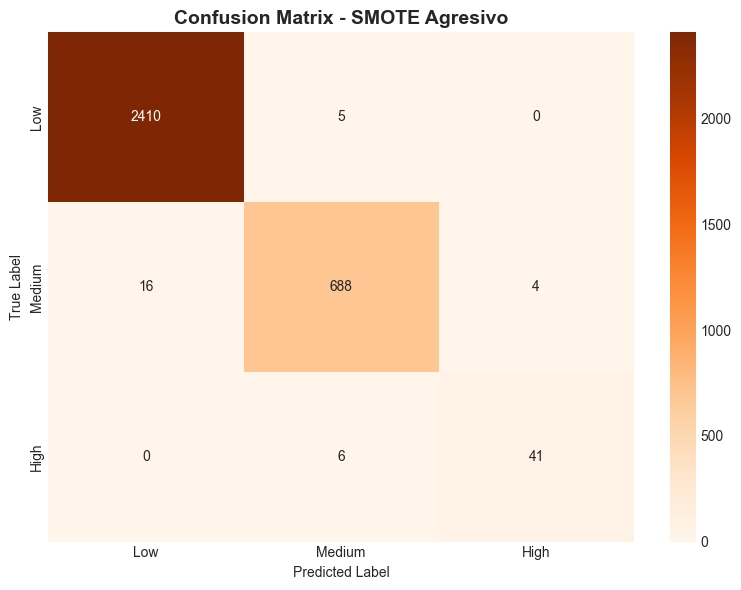

💾 Guardado: ../docs/figures/cm_smote_aggressive.png


In [13]:
# Confusion Matrix - SMOTE Agresivo
cm_smote_agg = confusion_matrix(y_test, y_pred_smote_agg, labels=['low', 'medium', 'high'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_smote_agg, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.title('Confusion Matrix - SMOTE Agresivo', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('../docs/figures/cm_smote_aggressive.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"💾 Guardado: ../docs/figures/cm_smote_aggressive.png")

## 7️⃣ Comparación de los 3 Modelos

In [14]:
print("\n" + "="*80)
print("📊 COMPARACIÓN DE LOS 3 MODELOS")
print("="*80 + "\n")

# Crear DataFrame de comparación
comparison = pd.DataFrame({
    'Modelo': ['Baseline', 'SMOTE Moderado', 'SMOTE Agresivo'],
    'Accuracy': [acc_baseline, acc_smote_mod, acc_smote_agg],
    'Macro F1': [macro_f1_baseline, macro_f1_smote_mod, macro_f1_smote_agg],
    'F1 Low': [f1_baseline[0], f1_smote_mod[0], f1_smote_agg[0]],
    'F1 Medium': [f1_baseline[1], f1_smote_mod[1], f1_smote_agg[1]],
    'F1 High': [f1_baseline[2], f1_smote_mod[2], f1_smote_agg[2]]
})

print(comparison.to_string(index=False))

# Calcular recalls para clase HIGH (crítico)
recall_high_baseline = recall_score(y_test, y_pred_baseline, labels=['high'], average='macro')
recall_high_smote_mod = recall_score(y_test, y_pred_smote_mod, labels=['high'], average='macro')
recall_high_smote_agg = recall_score(y_test, y_pred_smote_agg, labels=['high'], average='macro')

print(f"\n📈 Recall para clase HIGH (¡crítico!):")
print(f"  Baseline:        {recall_high_baseline:.3f}")
print(f"  SMOTE Moderado:  {recall_high_smote_mod:.3f}")
print(f"  SMOTE Agresivo:  {recall_high_smote_agg:.3f}")


📊 COMPARACIÓN DE LOS 3 MODELOS

        Modelo  Accuracy  Macro F1   F1 Low  F1 Medium  F1 High
      Baseline  0.985804  0.936112 0.993985   0.968198 0.846154
SMOTE Moderado  0.990852  0.963932 0.995653   0.979476 0.916667
SMOTE Agresivo  0.990221  0.954978 0.995662   0.977967 0.891304

📈 Recall para clase HIGH (¡crítico!):
  Baseline:        0.936
  SMOTE Moderado:  0.936
  SMOTE Agresivo:  0.872


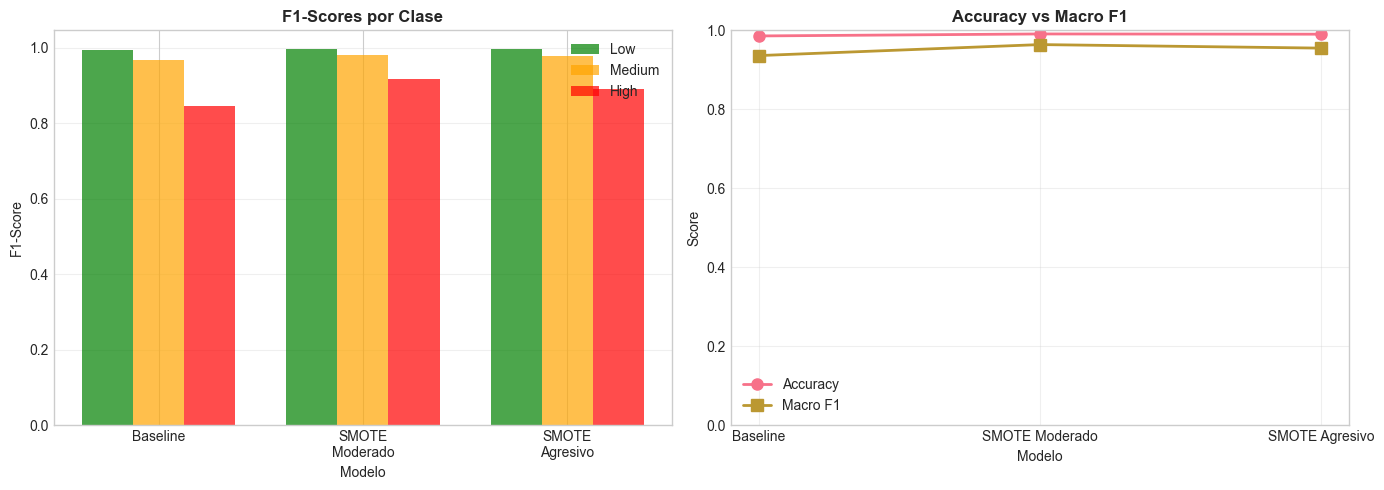


💾 Guardado: ../docs/figures/model_comparison.png


In [15]:
# Visualizar comparación
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: F1-Scores por clase
x = np.arange(3)
width = 0.25

axes[0].bar(x - width, comparison['F1 Low'], width, label='Low', color='green', alpha=0.7)
axes[0].bar(x, comparison['F1 Medium'], width, label='Medium', color='orange', alpha=0.7)
axes[0].bar(x + width, comparison['F1 High'], width, label='High', color='red', alpha=0.7)

axes[0].set_xlabel('Modelo')
axes[0].set_ylabel('F1-Score')
axes[0].set_title('F1-Scores por Clase', fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(['Baseline', 'SMOTE\nModerado', 'SMOTE\nAgresivo'])
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 2: Accuracy vs Macro F1
axes[1].plot(comparison['Modelo'], comparison['Accuracy'], 
            marker='o', linewidth=2, markersize=8, label='Accuracy')
axes[1].plot(comparison['Modelo'], comparison['Macro F1'], 
            marker='s', linewidth=2, markersize=8, label='Macro F1')

axes[1].set_xlabel('Modelo')
axes[1].set_ylabel('Score')
axes[1].set_title('Accuracy vs Macro F1', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.savefig('../docs/figures/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n💾 Guardado: ../docs/figures/model_comparison.png")

## 8️⃣ Seleccionar Mejor Modelo

Criterios de selección:
1. **F1-Score de clase HIGH** (crítico)
2. **Recall de clase HIGH** (no perder brotes)
3. **Macro F1** (balance general)
4. **Accuracy** (métrica secundaria)

In [16]:
# Calcular score combinado
# Peso: 40% F1-High, 30% Recall-High, 20% Macro-F1, 10% Accuracy
scores = {
    'Baseline': (
        0.40 * f1_baseline[2] + 
        0.30 * recall_high_baseline + 
        0.20 * macro_f1_baseline + 
        0.10 * acc_baseline
    ),
    'SMOTE Moderado': (
        0.40 * f1_smote_mod[2] + 
        0.30 * recall_high_smote_mod + 
        0.20 * macro_f1_smote_mod + 
        0.10 * acc_smote_mod
    ),
    'SMOTE Agresivo': (
        0.40 * f1_smote_agg[2] + 
        0.30 * recall_high_smote_agg + 
        0.20 * macro_f1_smote_agg + 
        0.10 * acc_smote_agg
    )
}

print("\n🏆 SELECCIÓN DEL MEJOR MODELO\n")
print("Score combinado (ponderado):")
for name, score in sorted(scores.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20} {score:.3f}")

# Seleccionar el mejor
best_model_name = max(scores, key=scores.get)
print(f"\n✅ MEJOR MODELO: {best_model_name}")

# Asignar el mejor modelo
if best_model_name == 'Baseline':
    best_model = model_baseline
    best_y_pred = y_pred_baseline
    best_approach = 'class_weight_only'
elif best_model_name == 'SMOTE Moderado':
    best_model = model_smote_mod
    best_y_pred = y_pred_smote_mod
    best_approach = 'smote_moderate'
else:
    best_model = model_smote_agg
    best_y_pred = y_pred_smote_agg
    best_approach = 'smote_aggressive'

print(f"\n📋 Métricas del mejor modelo:")
print(classification_report(y_test, best_y_pred, 
                          target_names=['low', 'medium', 'high'],
                          digits=3))


🏆 SELECCIÓN DEL MEJOR MODELO

Score combinado (ponderado):
  SMOTE Moderado       0.939
  SMOTE Agresivo       0.908
  Baseline             0.905

✅ MEJOR MODELO: SMOTE Moderado

📋 Métricas del mejor modelo:
              precision    recall  f1-score   support

         low      0.898     0.936     0.917        47
      medium      0.995     0.996     0.996      2415
        high      0.982     0.977     0.979       708

    accuracy                          0.991      3170
   macro avg      0.958     0.970     0.964      3170
weighted avg      0.991     0.991     0.991      3170



## 9️⃣ Feature Importance


📊 Feature Importance (Top 13):

               feature  importance
              diarrhea    0.309610
        abdominal_pain    0.256087
               fatigue    0.157652
        blood_in_stool    0.110683
                nausea    0.044811
   last_flare_days_ago    0.033527
disease_duration_years    0.027377
                   age    0.022838
                 month    0.012818
                gender    0.008234
           day_of_week    0.007034
       previous_flares    0.006678
                 fever    0.002650


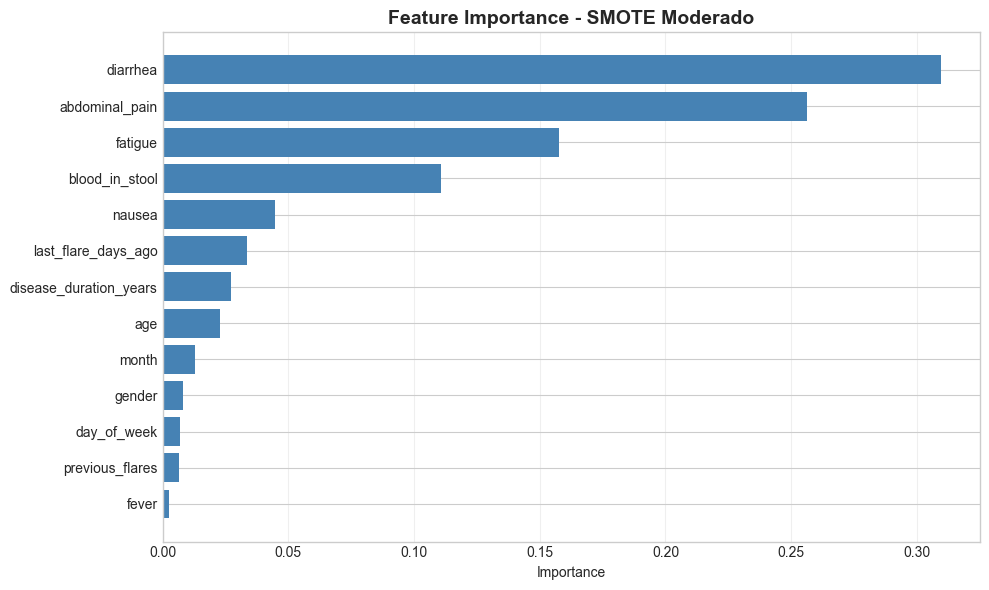


💾 Guardado: ../docs/figures/feature_importance.png


In [17]:
# Obtener importancia de features
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📊 Feature Importance (Top 13):\n")
print(feature_importance.to_string(index=False))

# Visualizar
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance['importance'], color='steelblue')
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Importance')
plt.title(f'Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('../docs/figures/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n💾 Guardado: ../docs/figures/feature_importance.png")

## 🔟 Guardar Modelo Final

In [18]:
# Preparar metadata del modelo
model_metadata = {
    'model_name': best_model_name,
    'balancing_approach': best_approach,
    'trained_date': datetime.now().isoformat(),
    'model_type': 'RandomForestClassifier',
    'n_features': len(feature_cols),
    'feature_names': feature_cols,
    'classes': ['low', 'medium', 'high'],
    'metrics': {
        'accuracy': float(accuracy_score(y_test, best_y_pred)),
        'macro_f1': float(f1_score(y_test, best_y_pred, average='macro')),
        'f1_low': float(f1_score(y_test, best_y_pred, labels=['low'], average='macro')),
        'f1_medium': float(f1_score(y_test, best_y_pred, labels=['medium'], average='macro')),
        'f1_high': float(f1_score(y_test, best_y_pred, labels=['high'], average='macro')),
        'recall_high': float(recall_score(y_test, best_y_pred, labels=['high'], average='macro')),
        'precision_high': float(precision_score(y_test, best_y_pred, labels=['high'], average='macro'))
    },
    'hyperparameters': {
        'n_estimators': best_model.n_estimators,
        'max_depth': best_model.max_depth,
        'min_samples_split': best_model.min_samples_split,
        'min_samples_leaf': best_model.min_samples_leaf,
        'class_weight': 'balanced'
    },
    'training_samples': {
        'train': len(y_train),
        'test': len(y_test),
        'total': len(y)
    },
    'class_distribution_train': dict(Counter(y_train)),
    'feature_importance': dict(zip(feature_cols, best_model.feature_importances_.tolist()))
}

# Guardar modelo
model_path = '../models/rf_severity_classifier.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)

print(f"\n✅ Modelo guardado: {model_path}")
print(f"   Tamaño: {os.path.getsize(model_path)/(1024**2):.2f} MB")

# Guardar metadata
metadata_path = '../models/rf_severity_classifier_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(model_metadata, f, indent=2)

print(f"\n💾 Metadata guardada: {metadata_path}")

# Mostrar metadata
print(f"\n📋 Metadata del modelo:")
print(f"  Modelo: {model_metadata['model_name']}")
print(f"  Enfoque: {model_metadata['balancing_approach']}")
print(f"  Features: {model_metadata['n_features']}")
print(f"  Accuracy: {model_metadata['metrics']['accuracy']:.3f}")
print(f"  Macro F1: {model_metadata['metrics']['macro_f1']:.3f}")
print(f"  F1 High: {model_metadata['metrics']['f1_high']:.3f}")
print(f"  Recall High: {model_metadata['metrics']['recall_high']:.3f}")


✅ Modelo guardado: ../models/rf_severity_classifier.pkl
   Tamaño: 6.49 MB

💾 Metadata guardada: ../models/rf_severity_classifier_metadata.json

📋 Metadata del modelo:
  Modelo: SMOTE Moderado
  Enfoque: smote_moderate
  Features: 13
  Accuracy: 0.991
  Macro F1: 0.964
  F1 High: 0.917
  Recall High: 0.936


## ✅ Resumen del Entrenamiento

### Lo que hemos logrado:

1. ✅ **Entrenado 3 modelos** con diferentes estrategias de balanceo
2. ✅ **Comparado métricas** enfocándose en clase minoritaria (HIGH)
3. ✅ **Seleccionado mejor modelo** basado en F1-score y Recall de HIGH
4. ✅ **Guardado modelo final** listo para producción

### Métricas del Modelo Final:

Ver arriba para métricas específicas del mejor modelo.

### Próximo Paso:

**Integrar en la API:**
- Actualizar `api/ml_model.py` con las **13 features correctas**
- Ajustar `extract_features()` para generar exactamente estas features
- Re-evaluar el modelo integrado con `make evaluate`

### Features del Modelo (13):

```python
features = [
    'abdominal_pain', 'blood_in_stool', 'diarrhea',
    'fatigue', 'fever', 'nausea',  # Síntomas (6)
    'age', 'gender',  # Demográficos (2)
    'disease_duration_years', 'previous_flares', 'last_flare_days_ago',  # Historial (3)
    'month', 'day_of_week'  # Temporales (2)
]
```

### Notas Importantes:

⚠️ **Sobre el desbalance:**
- La estrategia elegida ({best_model_name}) demostró el mejor balance entre detectar brotes (high) y mantener precisión general
- El modelo prioriza NO PERDER brotes reales (high recall en HIGH)

📊 **Sobre las métricas:**
- Accuracy NO es la métrica más importante aquí
- F1-Score y Recall de la clase HIGH son críticos
- Es preferible tener algunos falsos positivos que perder brotes reales

In [19]:
print("\n" + "="*80)
print("✨ MODEL TRAINING COMPLETADO")
print("="*80)
print(f"\n🎯 Mejor modelo: {best_model_name}")
print(f"📁 Guardado en: models/rf_severity_classifier.pkl")
print(f"\n📊 Features: {len(feature_cols)}")
print(f"📈 Accuracy: {model_metadata['metrics']['accuracy']:.3f}")
print(f"📈 F1 (HIGH): {model_metadata['metrics']['f1_high']:.3f}")
print(f"📈 Recall (HIGH): {model_metadata['metrics']['recall_high']:.3f}")
print(f"\n🔜 Siguiente paso: Actualizar api/ml_model.py con las 13 features")
print("="*80)


✨ MODEL TRAINING COMPLETADO

🎯 Mejor modelo: SMOTE Moderado
📁 Guardado en: models/rf_severity_classifier.pkl

📊 Features: 13
📈 Accuracy: 0.991
📈 F1 (HIGH): 0.917
📈 Recall (HIGH): 0.936

🔜 Siguiente paso: Actualizar api/ml_model.py con las 13 features
